In [1]:
# 导入必要的库
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
import seaborn as sns
from typing import Tuple, Optional
import warnings
warnings.filterwarnings('ignore')

# 设置随机种子保证结果可重现
torch.manual_seed(42)
np.random.seed(42)

# 检查是否有可用的GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用设备: {device}")

使用设备: cpu


In [2]:
# LSTM模型定义
class LSTMModel(nn.Module):
    """
    简单的LSTM模型用于序列预测
    
    Args:
        input_size (int): 输入特征维度
        hidden_size (int): 隐藏层维度
        num_layers (int): LSTM层数
        output_size (int): 输出维度
        dropout (float): Dropout概率
    """
    def __init__(self, input_size: int, hidden_size: int, num_layers: int, 
                 output_size: int, dropout: float = 0.2):
        super(LSTMModel, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # LSTM层
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        
        # Dropout层
        self.dropout = nn.Dropout(dropout)
        
        # 全连接输出层
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x: torch.Tensor, 
                hidden: Optional[Tuple[torch.Tensor, torch.Tensor]] = None) -> Tuple[torch.Tensor, Tuple[torch.Tensor, torch.Tensor]]:
        """
        前向传播
        
        Args:
            x (torch.Tensor): 输入张量，形状为 (batch_size, seq_len, input_size)
            hidden (Optional[Tuple]): 隐藏状态和细胞状态
            
        Returns:
            Tuple[torch.Tensor, Tuple[torch.Tensor, torch.Tensor]]: 输出和最终的隐藏状态
        """
        batch_size = x.size(0)
        
        # 初始化隐藏状态
        if hidden is None:
            hidden = self.init_hidden(batch_size)
        
        # LSTM前向传播
        lstm_out, hidden = self.lstm(x, hidden)
        
        # 应用dropout
        lstm_out = self.dropout(lstm_out)
        
        # 只取最后一个时间步的输出
        out = self.fc(lstm_out[:, -1, :])
        
        return out, hidden
    
    def init_hidden(self, batch_size: int) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        初始化隐藏状态
        
        Args:
            batch_size (int): 批次大小
            
        Returns:
            Tuple[torch.Tensor, torch.Tensor]: 初始化的隐藏状态和细胞状态
        """
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
        return h0, c0

In [ ]:
# 数据生成函数
def generate_sine_wave_data(seq_length: int = 50, num_samples: int = 1000, 
                           noise_level: float = 0.1) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    生成正弦波序列数据用于LSTM训练
    
    Args:
        seq_length (int): 序列长度
        num_samples (int): 样本数量
        noise_level (float): 噪声水平
        
    Returns:
        Tuple[torch.Tensor, torch.Tensor]: 输入序列和目标值
    """
    # 生成正弦波数据
    t = np.linspace(0, 4 * np.pi, num_samples + seq_length)
    data = np.sin(t) + noise_level * np.random.randn(len(t))
    
    # 创建序列数据
    X = []
    y = []
    
    for i in range(num_samples):
        # 输入序列
        X.append(data[i:i + seq_length])
        # 目标值（下一个时间点的值）
        y.append(data[i + seq_length])
    
    X = np.array(X)
    y = np.array(y)
    
    # 转换为PyTorch张量
    X = torch.FloatTensor(X).unsqueeze(-1)  # 添加特征维度
    y = torch.FloatTensor(y).unsqueeze(-1)
    
    return X, y


def create_data_loaders(X: torch.Tensor, y: torch.Tensor, 
                       batch_size: int = 32, 
                       train_ratio: float = 0.8) -> Tuple[DataLoader, DataLoader]:
    """
    创建训练和验证数据加载器
    
    Args:
        X (torch.Tensor): 输入数据
        y (torch.Tensor): 目标数据
        batch_size (int): 批次大小
        train_ratio (float): 训练集比例
        
    Returns:
        Tuple[DataLoader, DataLoader]: 训练和验证数据加载器
    """
    # 划分训练集和验证集
    total_samples = len(X)
    train_size = int(total_samples * train_ratio)
    
    X_train = X[:train_size]
    y_train = y[:train_size]
    X_val = X[train_size:]
    y_val = y[train_size:]
    
    # 创建数据集
    train_dataset = TensorDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val)
    
    # 创建数据加载器
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, val_loader


def visualize_data(X: torch.Tensor, y: torch.Tensor, num_samples: int = 5):
    """
    Visualize the generated data
    
    Args:
        X (torch.Tensor): Input sequences
        y (torch.Tensor): Target values
        num_samples (int): Number of samples to display
    """
    plt.figure(figsize=(12, 8))
    
    for i in range(min(num_samples, len(X))):
        plt.subplot(num_samples, 1, i + 1)
        sequence = X[i, :, 0].numpy()
        target = y[i, 0].item()
        
        plt.plot(range(len(sequence)), sequence, 'b-', label='Input Sequence', linewidth=2)
        plt.plot(len(sequence), target, 'ro', markersize=8, label='Target Value')
        plt.plot(len(sequence)-1, sequence[-1], 'go', markersize=8, label='Last Input')
        
        plt.title(f'Sample {i+1}')
        plt.ylabel('Value')
        plt.grid(True, alpha=0.3)
        if i == 0:
            plt.legend()
    
    plt.xlabel('Time Step')
    plt.tight_layout()
    plt.show()

In [4]:
# 训练函数
def train_epoch(model: nn.Module, train_loader: DataLoader, 
                criterion: nn.Module, optimizer: optim.Optimizer) -> Tuple[float, float]:
    """
    训练一个epoch
    
    Args:
        model (nn.Module): LSTM模型
        train_loader (DataLoader): 训练数据加载器
        criterion (nn.Module): 损失函数
        optimizer (optim.Optimizer): 优化器
        
    Returns:
        Tuple[float, float]: 平均损失和平均MSE
    """
    model.train()
    total_loss = 0.0
    total_mse = 0.0
    num_batches = 0
    
    for batch_idx, (sequences, targets) in enumerate(train_loader):
        sequences = sequences.to(device)
        targets = targets.to(device)
        
        # 前向传播
        optimizer.zero_grad()
        outputs, _ = model(sequences)
        
        # 计算损失
        loss = criterion(outputs, targets)
        
        # 反向传播
        loss.backward()
        
        # 梯度裁剪（防止梯度爆炸）
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        # 统计损失
        total_loss += loss.item()
        mse = torch.mean((outputs - targets) ** 2).item()
        total_mse += mse
        num_batches += 1
        
        # 打印进度
        if batch_idx % 50 == 0:
            print(f'批次 [{batch_idx}/{len(train_loader)}], 损失: {loss.item():.6f}')
    
    avg_loss = total_loss / num_batches
    avg_mse = total_mse / num_batches
    
    return avg_loss, avg_mse


def validate_epoch(model: nn.Module, val_loader: DataLoader, 
                   criterion: nn.Module) -> Tuple[float, float]:
    """
    验证一个epoch
    
    Args:
        model (nn.Module): LSTM模型
        val_loader (DataLoader): 验证数据加载器
        criterion (nn.Module): 损失函数
        
    Returns:
        Tuple[float, float]: 平均损失和平均MSE
    """
    model.eval()
    total_loss = 0.0
    total_mse = 0.0
    num_batches = 0
    
    with torch.no_grad():
        for sequences, targets in val_loader:
            sequences = sequences.to(device)
            targets = targets.to(device)
            
            # 前向传播
            outputs, _ = model(sequences)
            
            # 计算损失
            loss = criterion(outputs, targets)
            
            # 统计损失
            total_loss += loss.item()
            mse = torch.mean((outputs - targets) ** 2).item()
            total_mse += mse
            num_batches += 1
    
    avg_loss = total_loss / num_batches
    avg_mse = total_mse / num_batches
    
    return avg_loss, avg_mse

In [5]:
# 主训练循环
def train_model(model: nn.Module, train_loader: DataLoader, val_loader: DataLoader,
                num_epochs: int = 50, learning_rate: float = 0.001,
                patience: int = 10) -> Tuple[dict, nn.Module]:
    """
    完整的训练循环
    
    Args:
        model (nn.Module): LSTM模型
        train_loader (DataLoader): 训练数据加载器
        val_loader (DataLoader): 验证数据加载器
        num_epochs (int): 训练轮数
        learning_rate (float): 学习率
        patience (int): 早停耐心值
        
    Returns:
        Tuple[dict, nn.Module]: 训练历史和最佳模型
    """
    # 定义损失函数和优化器
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', 
                                                   factor=0.5, patience=5, verbose=True)
    
    # 记录训练历史
    history = {
        'train_loss': [],
        'train_mse': [],
        'val_loss': [],
        'val_mse': [],
        'learning_rate': []
    }
    
    # 早停相关变量
    best_val_loss = float('inf')
    epochs_without_improvement = 0
    best_model_state = None
    
    print("开始训练...")
    print("-" * 60)
    
    for epoch in range(num_epochs):
        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print('-' * 30)
        
        # 训练阶段
        train_loss, train_mse = train_epoch(model, train_loader, criterion, optimizer)
        
        # 验证阶段
        val_loss, val_mse = validate_epoch(model, val_loader, criterion)
        
        # 学习率调度
        scheduler.step(val_loss)
        current_lr = optimizer.param_groups[0]['lr']
        
        # 记录历史
        history['train_loss'].append(train_loss)
        history['train_mse'].append(train_mse)
        history['val_loss'].append(val_loss)
        history['val_mse'].append(val_mse)
        history['learning_rate'].append(current_lr)
        
        # 打印epoch结果
        print(f'训练损失: {train_loss:.6f}, 训练MSE: {train_mse:.6f}')
        print(f'验证损失: {val_loss:.6f}, 验证MSE: {val_mse:.6f}')
        print(f'学习率: {current_lr:.6f}')
        
        # 早停检查
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
            best_model_state = model.state_dict().copy()
            print(f'新的最佳验证损失: {best_val_loss:.6f}')
        else:
            epochs_without_improvement += 1
            print(f'没有改善的轮数: {epochs_without_improvement}/{patience}')
        
        print('-' * 60)
        
        # 早停
        if epochs_without_improvement >= patience:
            print(f'早停！在epoch {epoch+1}停止训练')
            break
    
    # 加载最佳模型
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f'加载最佳模型，验证损失: {best_val_loss:.6f}')
    
    return history, model

In [ ]:
# Visualization Functions
def plot_training_history(history: dict):
    """
    Plot the training history
    
    Args:
        history (dict): Dictionary containing training history
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Train and Validation Loss
    axes[0, 0].plot(history['train_loss'], label='Train Loss', linewidth=2)
    axes[0, 0].plot(history['val_loss'], label='Validation Loss', linewidth=2)
    axes[0, 0].set_title('Train and Validation Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Train and Validation MSE
    axes[0, 1].plot(history['train_mse'], label='Train MSE', linewidth=2)
    axes[0, 1].plot(history['val_mse'], label='Validation MSE', linewidth=2)
    axes[0, 1].set_title('Train and Validation MSE')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('MSE')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Learning Rate Schedule
    axes[1, 0].plot(history['learning_rate'], label='Learning Rate', linewidth=2, color='red')
    axes[1, 0].set_title('Learning Rate Schedule')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Learning Rate')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].set_yscale('log')
    
    # Loss Comparison (Log Scale)
    axes[1, 1].plot(history['train_loss'], label='Train Loss', linewidth=2)
    axes[1, 1].plot(history['val_loss'], label='Validation Loss', linewidth=2)
    axes[1, 1].set_title('Loss Comparison (Log Scale)')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Loss')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].set_yscale('log')
    
    plt.tight_layout()
    plt.show()


def plot_predictions(model: nn.Module, X_test: torch.Tensor, y_test: torch.Tensor, 
                    num_samples: int = 10):
    """
    Plot prediction comparisons
    
    Args:
        model (nn.Module): Trained model
        X_test (torch.Tensor): Test inputs
        y_test (torch.Tensor): Test targets
        num_samples (int): Number of samples to display
    """
    model.eval()
    
    with torch.no_grad():
        X_test = X_test.to(device)
        predictions, _ = model(X_test)
        predictions = predictions.cpu().numpy()
        y_test = y_test.numpy()
    
    plt.figure(figsize=(15, 12))
    
    for i in range(min(num_samples, len(X_test))):
        plt.subplot(num_samples, 1, i + 1)
        
        # Plot input sequence
        sequence = X_test[i, :, 0].cpu().numpy()
        plt.plot(range(len(sequence)), sequence, 'b-', label='Input Sequence', linewidth=2, alpha=0.7)
        
        # Plot true and predicted values
        true_value = y_test[i, 0]
        pred_value = predictions[i, 0]
        
        plt.plot(len(sequence), true_value, 'go', markersize=10, label=f'True Value: {true_value:.3f}')
        plt.plot(len(sequence), pred_value, 'ro', markersize=10, label=f'Predicted Value: {pred_value:.3f}')
        
        # Calculate error
        error = abs(true_value - pred_value)
        plt.title(f'Sample {i+1} - Error: {error:.4f}')
        plt.ylabel('Value')
        plt.grid(True, alpha=0.3)
        
        if i == 0:
            plt.legend()
    
    plt.xlabel('Time Step')
    plt.tight_layout()
    plt.show()


def plot_prediction_scatter(y_true: torch.Tensor, y_pred: torch.Tensor):
    """
    Plot a scatter plot of predicted values
    
    Args:
        y_true (torch.Tensor): True values
        y_pred (torch.Tensor): Predicted values
    """
    y_true_np = y_true.numpy().flatten()
    y_pred_np = y_pred.numpy().flatten()
    
    plt.figure(figsize=(10, 8))
    
    # Scatter plot
    plt.scatter(y_true_np, y_pred_np, alpha=0.6, s=30)
    
    # Ideal prediction line
    min_val = min(y_true_np.min(), y_pred_np.min())
    max_val = max(y_true_np.max(), y_pred_np.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Ideal Prediction')
    
    # Calculate R²
    ss_res = np.sum((y_true_np - y_pred_np) ** 2)
    ss_tot = np.sum((y_true_np - np.mean(y_true_np)) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    
    # Calculate MSE
    mse = np.mean((y_true_np - y_pred_np) ** 2)
    
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Predicted vs True Values\nR² = {r2:.4f}, MSE = {mse:.6f}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Add text box
    textstr = f'R² = {r2:.4f}\nMSE = {mse:.6f}\nRMSE = {np.sqrt(mse):.6f}'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=10,
             verticalalignment='top', bbox=props)
    
    plt.tight_layout()
    plt.show()

LSTM序列预测项目
序列长度: 50
样本数量: 1000
批次大小: 32
隐藏层大小: 64
LSTM层数: 2
训练轮数: 50
学习率: 0.001

1. 生成数据...
数据形状 - X: torch.Size([1000, 50, 1]), y: torch.Size([1000, 1])

2. 创建数据加载器...
训练批次数: 25
验证批次数: 7

3. 可视化数据样本...


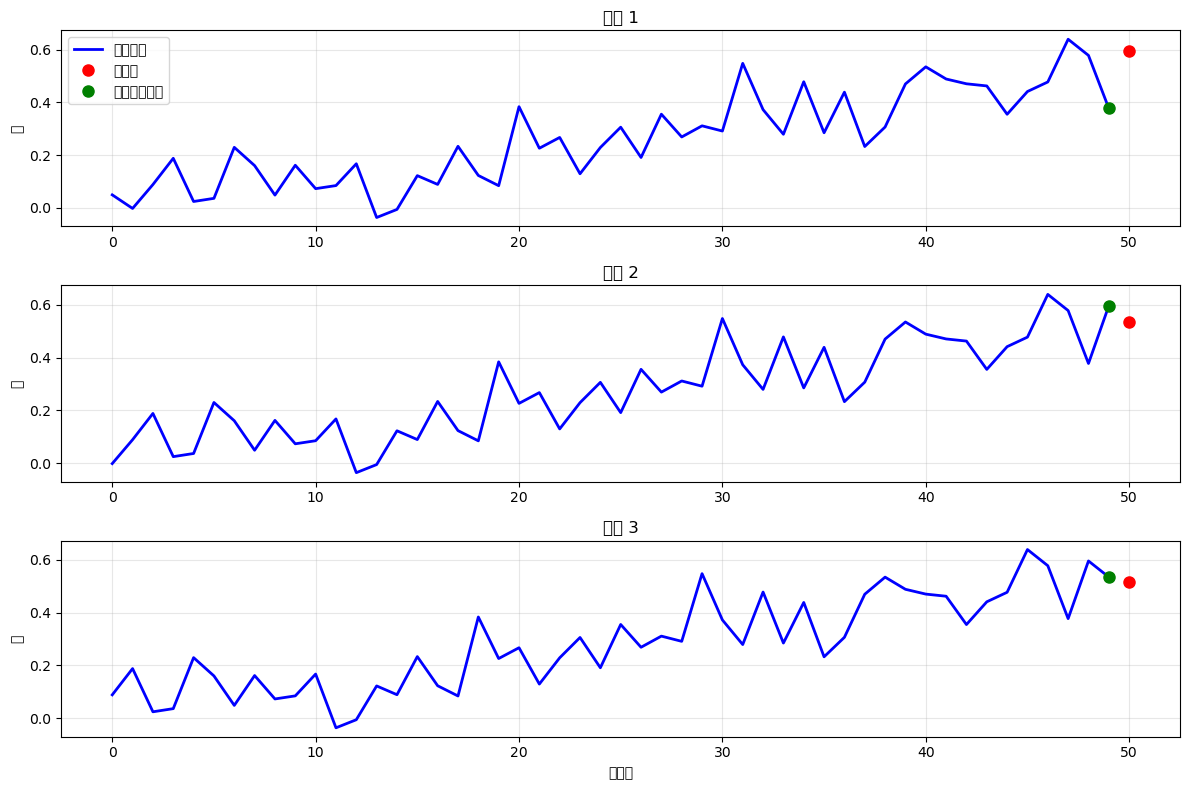


4. 创建LSTM模型...
模型总参数数: 50,497
可训练参数数: 50,497

5. 开始训练模型...
开始训练...
------------------------------------------------------------
Epoch [1/50]
------------------------------
批次 [0/25], 损失: 0.477615
开始训练...
------------------------------------------------------------
Epoch [1/50]
------------------------------
批次 [0/25], 损失: 0.477615
训练损失: 0.334621, 训练MSE: 0.334621
验证损失: 0.066078, 验证MSE: 0.066078
学习率: 0.001000
新的最佳验证损失: 0.066078
------------------------------------------------------------
Epoch [2/50]
------------------------------
批次 [0/25], 损失: 0.038952
训练损失: 0.334621, 训练MSE: 0.334621
验证损失: 0.066078, 验证MSE: 0.066078
学习率: 0.001000
新的最佳验证损失: 0.066078
------------------------------------------------------------
Epoch [2/50]
------------------------------
批次 [0/25], 损失: 0.038952
训练损失: 0.035355, 训练MSE: 0.035355
验证损失: 0.027893, 验证MSE: 0.027893
学习率: 0.001000
新的最佳验证损失: 0.027893
------------------------------------------------------------
Epoch [3/50]
------------------------------
批次 [0/25], 损

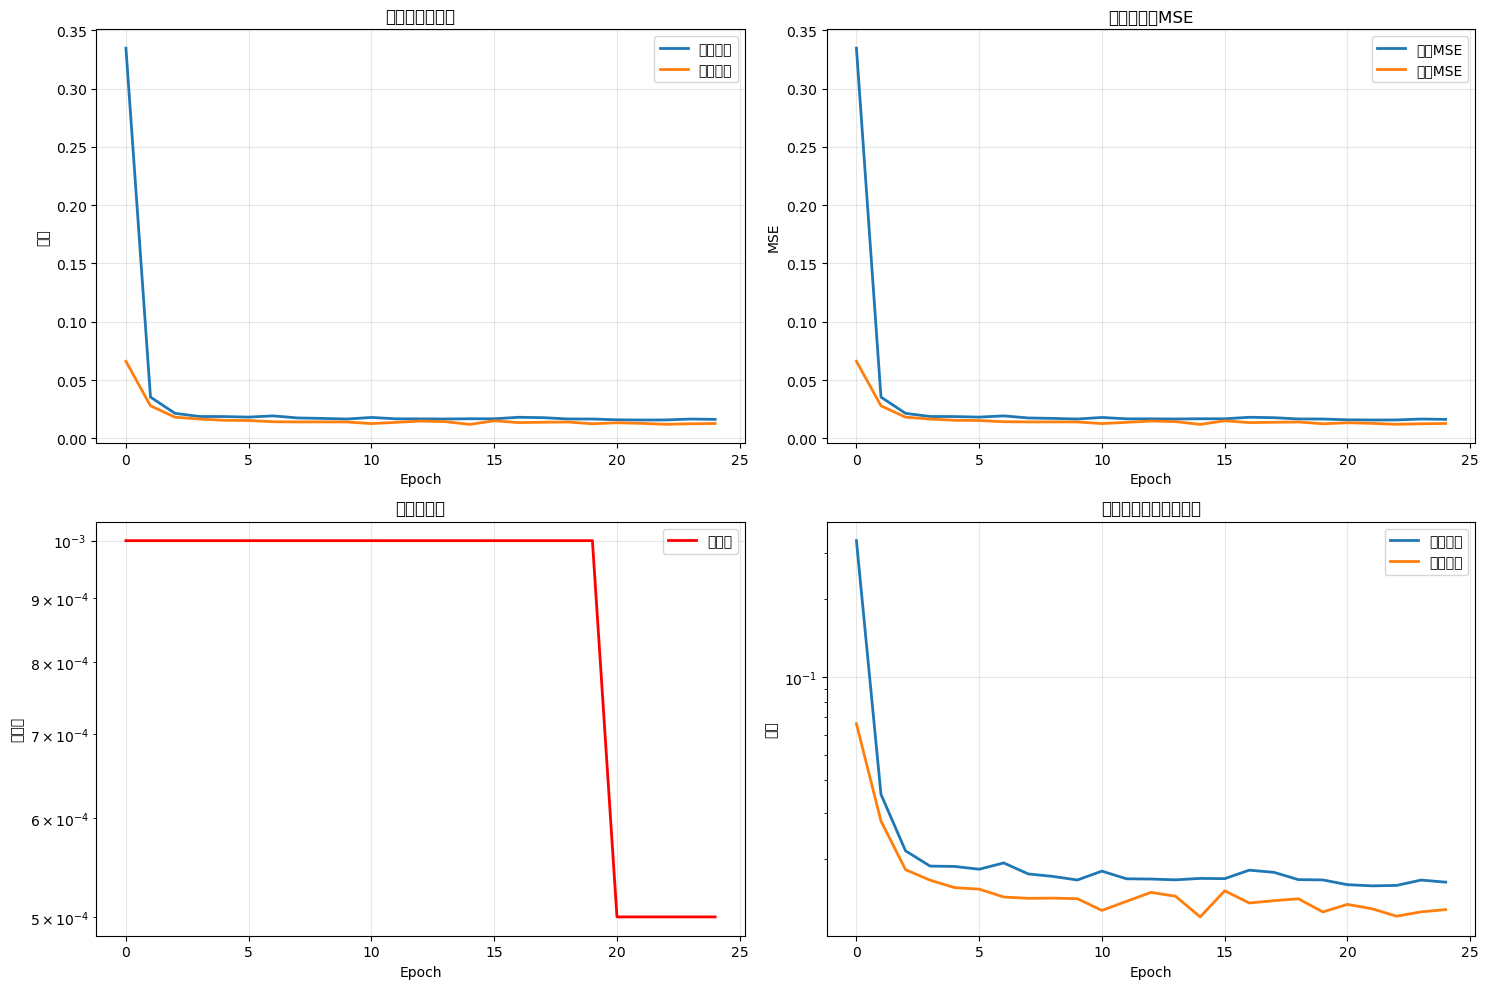


7. 评估模型性能...
最终验证MSE: 0.012156
最终验证RMSE: 0.110255
最终验证R²: 0.867885

8. 可视化预测结果...


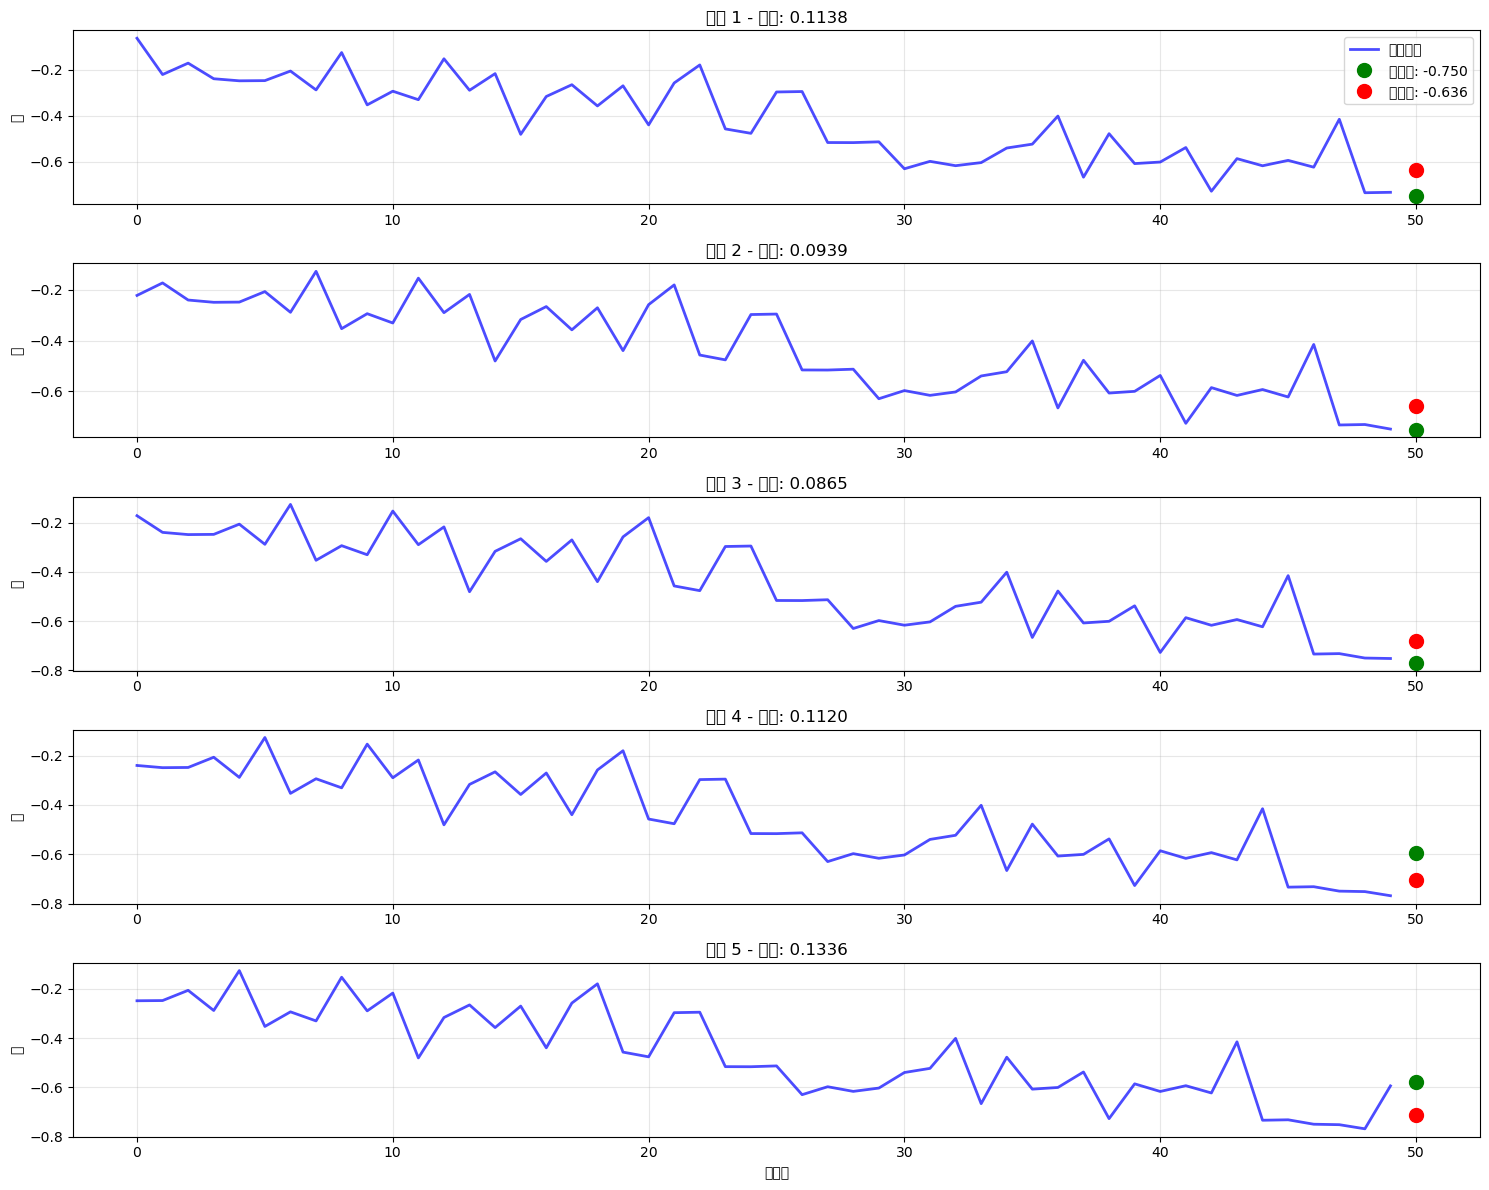

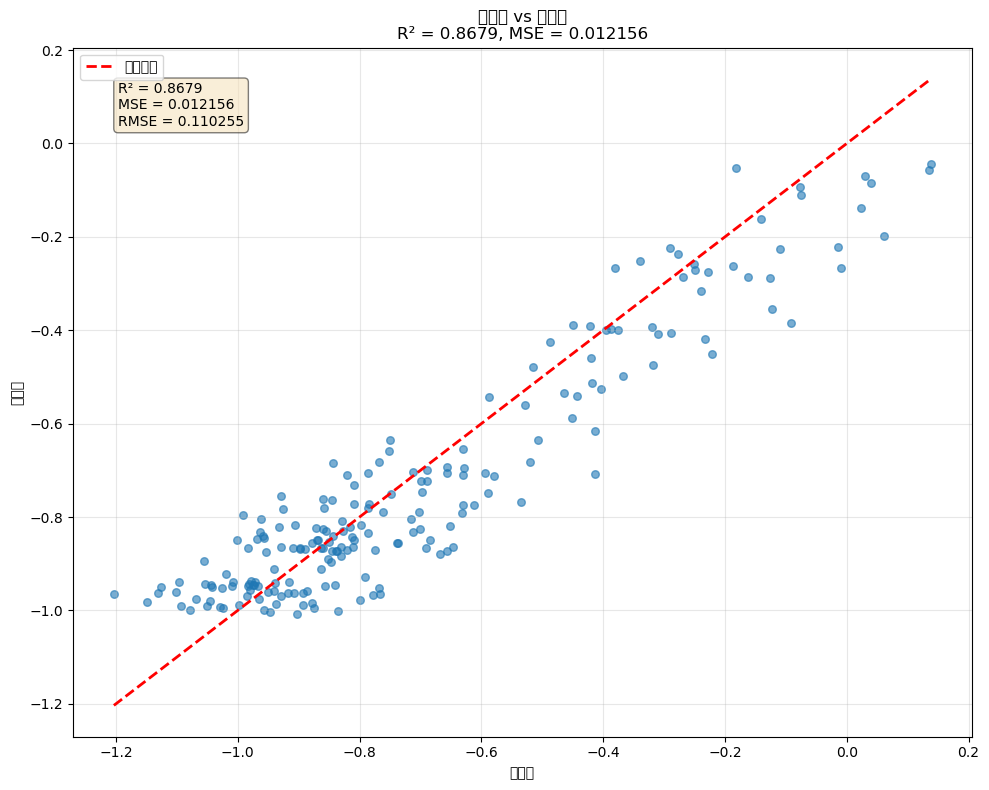


项目完成！


In [ ]:
# 主执行函数
def main():
    """
    主执行函数 - 整合所有功能
    """
    # 设置参数
    SEQ_LENGTH = 50
    NUM_SAMPLES = 1000
    NOISE_LEVEL = 0.1
    BATCH_SIZE = 32
    HIDDEN_SIZE = 64
    NUM_LAYERS = 2
    NUM_EPOCHS = 50
    LEARNING_RATE = 0.001
    
    print("=" * 60)
    print("LSTM Sequence Prediction Project")
    print("=" * 60)
    print(f"Sequence Length: {SEQ_LENGTH}")
    print(f"Number of Samples: {NUM_SAMPLES}")
    print(f"Batch Size: {BATCH_SIZE}")
    print(f"Hidden Size: {HIDDEN_SIZE}")
    print(f"LSTM Layers: {NUM_LAYERS}")
    print(f"Number of Epochs: {NUM_EPOCHS}")
    print(f"Learning Rate: {LEARNING_RATE}")
    print("=" * 60)
    
    # 1. Generate data...
    print("\n1. Generate data...")
    X, y = generate_sine_wave_data(SEQ_LENGTH, NUM_SAMPLES, NOISE_LEVEL)
    print(f"Data shape - X: {X.shape}, y: {y.shape}")
    
    # 2. Create data loaders...
    print("\n2. Create data loaders...")
    train_loader, val_loader = create_data_loaders(X, y, BATCH_SIZE)
    print(f"Number of training batches: {len(train_loader)}")
    print(f"Number of validation batches: {len(val_loader)}")
    
    # 3. Visualize some data samples...
    print("\n3. Visualize some data samples...")
    visualize_data(X, y, num_samples=3)
    
    # 4. Create LSTM model...
    print("\n4. Create LSTM model...")
    model = LSTMModel(
        input_size=1,
        hidden_size=HIDDEN_SIZE,
        num_layers=NUM_LAYERS,
        output_size=1,
        dropout=0.2
    ).to(device)
    
    # 计算模型参数数量
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total model parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    
    # 5. Start training model...
    print("\n5. Start training model...")
    history, trained_model = train_model(
        model, train_loader, val_loader, 
        num_epochs=NUM_EPOCHS,
        learning_rate=LEARNING_RATE,
        patience=10
    )
    
    # 6. Visualize training history...
    print("\n6. Visualize training history...")
    plot_training_history(history)
    
    # 7. Evaluate model performance...
    print("\n7. Evaluate model performance...")
    
    # 获取验证数据进行预测
    val_X = []
    val_y = []
    for sequences, targets in val_loader:
        val_X.append(sequences)
        val_y.append(targets)
    
    val_X = torch.cat(val_X, dim=0)
    val_y = torch.cat(val_y, dim=0)
    
    # 进行预测
    trained_model.eval()
    with torch.no_grad():
        val_X = val_X.to(device)
        predictions, _ = trained_model(val_X)
        predictions = predictions.cpu()
    
    # 计算最终指标
    final_mse = torch.mean((predictions - val_y) ** 2).item()
    final_rmse = np.sqrt(final_mse)
    
    # 计算R²
    y_mean = torch.mean(val_y)
    ss_tot = torch.sum((val_y - y_mean) ** 2)
    ss_res = torch.sum((val_y - predictions) ** 2)
    r2 = 1 - (ss_res / ss_tot).item()
    
    print(f"Final Validation MSE: {final_mse:.6f}")
    print(f"Final Validation RMSE: {final_rmse:.6f}")
    print(f"Final Validation R²: {r2:.6f}")
    
    # 8. Visualize prediction results...
    print("\n8. Visualize prediction results...")
    plot_predictions(trained_model, val_X[:10], val_y[:10], num_samples=5)
    plot_prediction_scatter(val_y, predictions)
    
    print("\n" + "=" * 60)
    print("Project finished!")
    print("=" * 60)
    
    return trained_model, history, predictions, val_y


# Run main function
if __name__ == "__main__":
    model, history, predictions, true_values = main()